# CMX Sky Surface Brightness
So far I've been estimating the sky flux by applying flux correction to the `sky` data. This however overestimates the sky since it includes the (transparency) and (fiber fraction) within the flux calibration. 

$(\mathtt{sky~surface~brightness}) = (\mathtt{sky~electrons})/(\mathtt{throughput})/(\mathtt{instrument~photons~per~bin})/(\mathtt{exp.~time})/(\mathtt{fiber~area})$

where $(\mathtt{sky~electrons})$ is the flat fielded sky fiber data

In [1]:
import os
import fitsio
import numpy as np 
from scipy.signal import medfilt
import astropy.units as u

import desisim.simexp
import specsim.instrument
from desispec.io import read_sky
from desispec.io import read_frame
from desimodel.io import load_throughput

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
tileid = 70502
date = 20200225
expid = 52113
ispec = 0 

dir_redux = "/global/cfs/cdirs/desi/spectro/redux/daily" 
dir_coadd = '/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/'

In [4]:
wavemin = load_throughput('b').wavemin - 10.0
wavemax = load_throughput('z').wavemax + 10.0
wave = np.arange(round(wavemin, 1), wavemax, 0.2) * u.Angstrom

# Generate specsim config object for a given wavelength grid
config = desisim.simexp._specsim_config_for_wave(wave.to('Angstrom').value, dwave_out=0.8, specsim_config_file='desi')

In [5]:
f_sky = lambda band: os.path.join(dir_redux, 'exposures', str(date), str(expid).zfill(8), 
                                  'sky-%s%i-%s.fits' % (band, ispec, str(expid).zfill(8)))
sky_b = read_sky(f_sky('b'))
sky_r = read_sky(f_sky('r'))
sky_z = read_sky(f_sky('z'))

In [6]:
med_sky_b = sky_b.flux[268]
med_sky_r = sky_r.flux[268]
med_sky_z = sky_z.flux[268]

In [7]:
med_sky_b_smooth = np.interp(wave, sky_b.wave, medfilt(med_sky_b, 301))
med_sky_b_smooth[(wave.value < sky_b.wave.min()) | (wave.value > sky_b.wave.max())] = 0.

med_sky_r_smooth = np.interp(wave, sky_r.wave, medfilt(med_sky_r, 301))
med_sky_r_smooth[(wave.value < sky_r.wave.min()) | (wave.value > sky_r.wave.max())] = 0.

med_sky_z_smooth = np.interp(wave, sky_z.wave, medfilt(med_sky_z, 301))
med_sky_z_smooth[(wave.value < sky_z.wave.min()) | (wave.value > sky_z.wave.max())] = 0.

(0.0, 300)

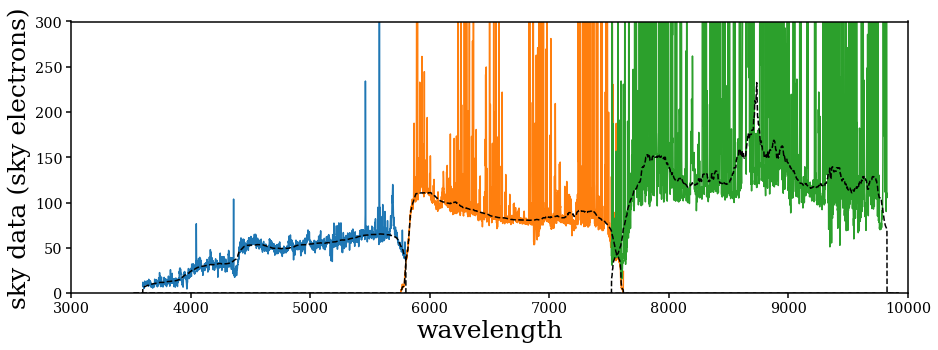

In [8]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

sub.plot(sky_b.wave, med_sky_b)
sub.plot(sky_r.wave, med_sky_r)
sub.plot(sky_z.wave, med_sky_z)

sub.plot(wave, med_sky_b_smooth, c='k', ls='--')
sub.plot(wave, med_sky_r_smooth, c='k', ls='--')
sub.plot(wave, med_sky_z_smooth, c='k', ls='--')

sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(3e3, 1e4)
sub.set_ylabel('sky data (sky electrons)', fontsize=25)
sub.set_ylim(0., 300)

# sky photons

$(\mathtt{sky~photons}) = (\mathtt{sky~electrons})/(\mathtt{throughput})$

In [9]:
instrument = specsim.instrument.initialize(config, True)

(0.0, 1)

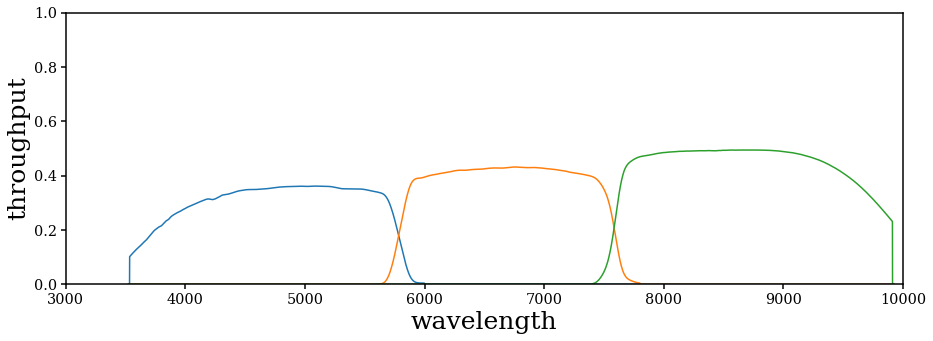

In [10]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
for camera in instrument.cameras: 
    sub.plot(wave, camera.throughput)
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(3e3, 1e4)
sub.set_ylabel('throughput', fontsize=25)
sub.set_ylim(0., 1)

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


(0.0, 400)

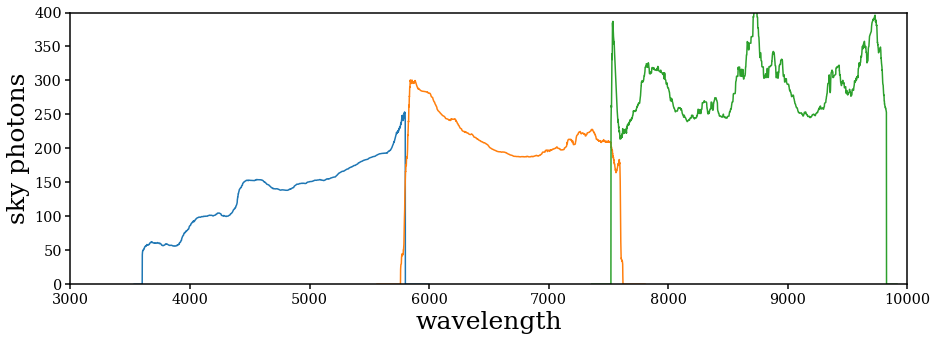

In [11]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
for camera, sky in zip(instrument.cameras, [med_sky_b_smooth, med_sky_r_smooth, med_sky_z_smooth]): 
    sub.plot(wave, sky/camera.throughput)
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(3e3, 1e4)
sub.set_ylabel('sky photons', fontsize=25)
sub.set_ylim(0., 400)

# sky fiber flux
$(\mathtt{sky~fiber~flux}) = (\mathtt{sky~electrons})/(\mathtt{throughput})/(\mathtt{instrument~photons~per~bin})/(\mathtt{exp.~time})$

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


(0.0, 20)

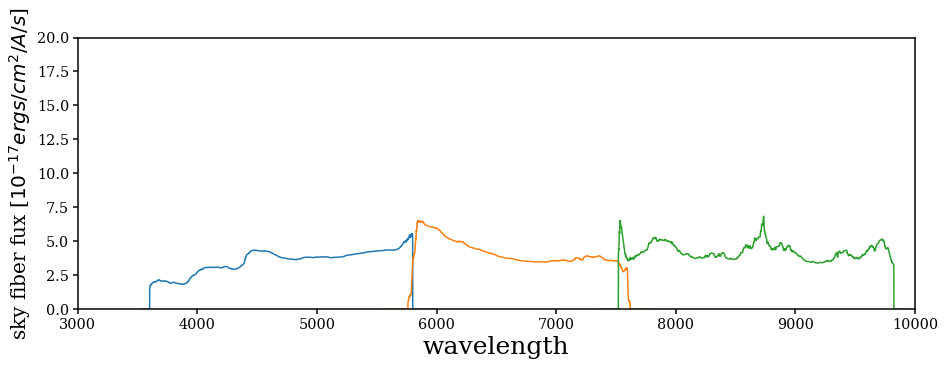

In [12]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
for camera, sky in zip(instrument.cameras, [med_sky_b_smooth, med_sky_r_smooth, med_sky_z_smooth]): 
    sub.plot(wave, sky / camera.throughput / instrument.photons_per_bin / 900. * 1e17)
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(3e3, 1e4)
sub.set_ylabel('sky fiber fux [$10^{-17} ergs/cm^2/A/s$]', fontsize=20)
sub.set_ylim(0., 20)

In [13]:
f_calib = lambda band: os.path.join(dir_redux, 'exposures', str(date), str(expid).zfill(8), 
                                    'fluxcalib-%s%i-%s.fits' % (band, ispec, str(expid).zfill(8)))
calib_b = fitsio.read(f_calib('b'))
calib_r = fitsio.read(f_calib('r'))
calib_z = fitsio.read(f_calib('z'))

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


(0.0, 20)

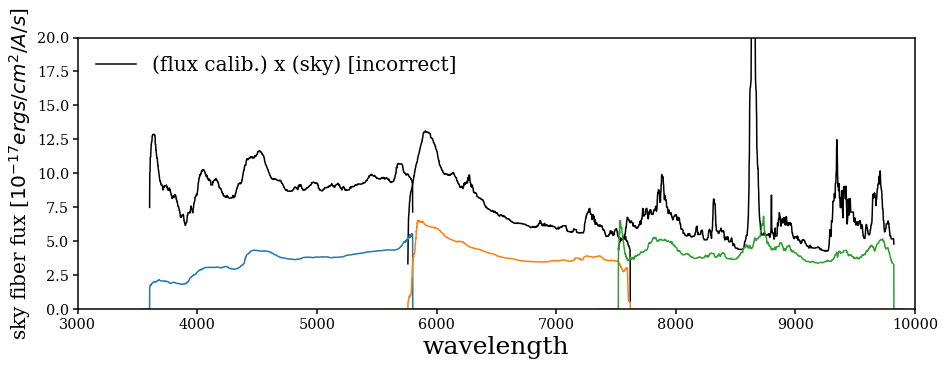

In [14]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(sky_b.wave, medfilt(med_sky_b / calib_b[268,:], 101), c='k')
sub.plot(sky_r.wave, medfilt(med_sky_r / calib_r[268,:], 101), c='k')
sub.plot(sky_z.wave, medfilt(med_sky_z / calib_z[268,:], 101), c='k', label='(flux calib.) x (sky) [incorrect]')

for camera, sky in zip(instrument.cameras, [med_sky_b_smooth, med_sky_r_smooth, med_sky_z_smooth]): 
    sub.plot(wave, sky / camera.throughput / instrument.photons_per_bin / 900. * 1e17)
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(3e3, 1e4)
sub.set_ylabel('sky fiber fux [$10^{-17} ergs/cm^2/A/s$]', fontsize=20)
sub.set_ylim(0., 20)

# sky surface brightness

In [15]:
desi_fiber_area = (1.46/2.)**2 * np.pi

In [16]:
nominal_surface_brightness_dict = config.load_table(config.atmosphere.sky, 'surface_brightness', as_dict=True)

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


(0.0, 10)

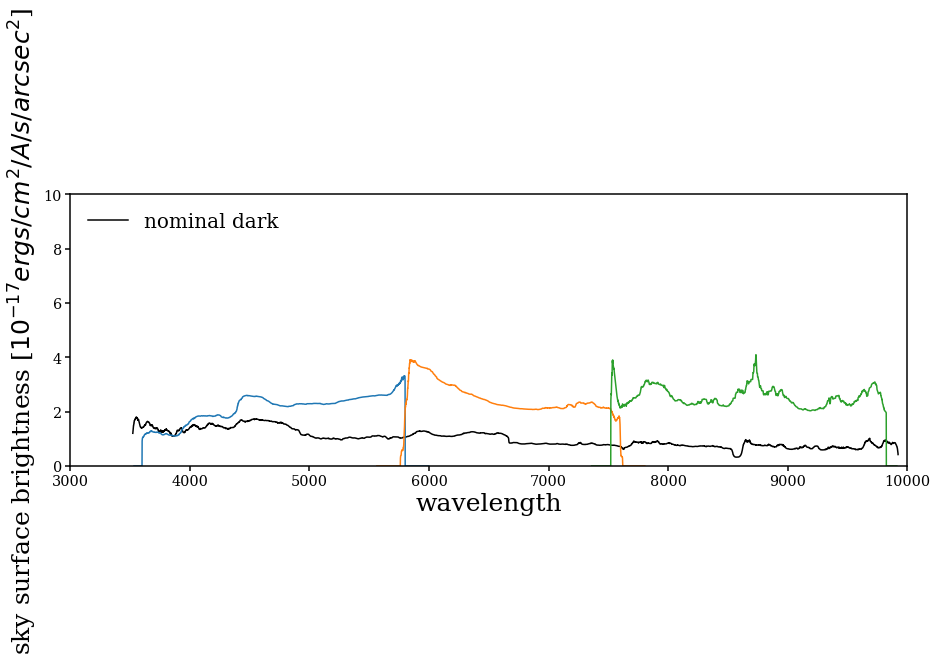

In [17]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(wave.value, medfilt(nominal_surface_brightness_dict['dark'].value, 301), c='k', label='nominal dark')

for camera, sky in zip(instrument.cameras, [med_sky_b_smooth, med_sky_r_smooth, med_sky_z_smooth]): 
    sub.plot(wave, sky / camera.throughput / instrument.photons_per_bin / 900. /desi_fiber_area * 1e17)
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(3e3, 1e4)
sub.set_ylabel('sky surface brightness [$10^{-17} ergs/cm^2/A/s/arcsec^2$]', fontsize=25)
sub.set_ylim(0., 10)